# Import Libraries/Packages & Datasets

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import copy

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(5703)
torch.manual_seed(5703)
np.random.seed(5703)
random.seed(5703)

In [72]:
#load data
import os
attackdata = {}
os.chdir('C:/Final Year Project/idsattacks')
for i in os.listdir():
  if i != 'Benign.csv':
    attackdata[i] = pd.read_csv(i)
    attackdata[i].drop(['Dst Port', 'Timestamp', 'Flow Byts/s', 'Flow Pkts/s'], axis=1, inplace=True)


In [73]:
attackdata["Bot.csv"]

,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,16079,3,4,326,129.0,326,0,108.666667,188.216188,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
1,6,577,2,0,0,0.0,0,0,0.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
2,6,10279,3,4,326,129.0,326,0,108.666667,188.216188,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
3,6,457,2,0,0,0.0,0,0,0.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
4,6,10271,3,4,326,129.0,326,0,108.666667,188.216188,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286186,0,9487,10,0,0,0.0,0,0,0.000000,0.000000,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
286187,6,1030059,4,2,0,0.0,0,0,0.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
286188,6,1029998,4,2,0,0.0,0,0,0.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
286189,6,1030017,4,2,0,0.0,0,0,0.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot


In [74]:
bendata = pd.read_csv('C:/Final Year Project/idsattacks/Benign.csv')
#bendata.drop(['Unnamed: 0'], axis=1, inplace=True)

In [75]:
#checking for unwanted columns
for i in attackdata:
  for j in ['Flow ID', 'Src IP', 'Src Port', 'Dst IP']:
    if j in attackdata[i].columns:
      print(i + " : " + j)
#attackdata[i].drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP'], axis=1, inplace=True)

In [76]:
for i in ['Flow ID', 'Src IP', 'Src Port', 'Dst IP']:
    if i in bendata.columns:
      print('bendata' + " : " + i)
#bendata.drop(['Label'],axis=1,inplace=True)

In [77]:
attbenmixdata = {}
mixbendata = bendata[:int(bendata.shape[0]*0.05)]
for i in attackdata:
  if attackdata[i].shape[0] > 100000:
    print(i)
    attbenmixdata[i] = pd.concat([attackdata[i][:int(attackdata[i].shape[0]*0.7)], mixbendata], axis=0)
    attbenmixdata[i] = attbenmixdata[i].sample(frac=1).reset_index(drop=True)

Bot.csv
DDOS attack-HOIC.csv
DDoS attacks-LOIC-HTTP.csv
DoS attacks-Hulk.csv
DoS attacks-SlowHTTPTest.csv
FTP-BruteForce.csv
Infilteration.csv
SSH-Bruteforce.csv


In [78]:
for i in attbenmixdata:
  print(i + " : " + str(attbenmixdata[i].shape))
  print(attbenmixdata[i]['Label'].value_counts())

Bot.csv : (323198, 77)
Label
Bot       200333
Benign    122865
Name: count, dtype: int64
DDOS attack-HOIC.csv : (603073, 77)
Label
DDOS attack-HOIC    480208
Benign              122865
Name: count, dtype: int64
DDoS attacks-LOIC-HTTP.csv : (526198, 77)
Label
DDoS attacks-LOIC-HTTP    403333
Benign                    122865
Name: count, dtype: int64
DoS attacks-Hulk.csv : (446203, 77)
Label
DoS attacks-Hulk    323338
Benign              122865
Name: count, dtype: int64
DoS attacks-SlowHTTPTest.csv : (220788, 77)
Label
Benign                      122865
DoS attacks-SlowHTTPTest     97923
Name: count, dtype: int64
FTP-BruteForce.csv : (258212, 77)
Label
FTP-BruteForce    135347
Benign            122865
Name: count, dtype: int64
Infilteration.csv : (235382, 77)
Label
Benign           122865
Infilteration    112517
Name: count, dtype: int64
SSH-Bruteforce.csv : (254177, 77)
Label
SSH-Bruteforce    131312
Benign            122865
Name: count, dtype: int64


In [79]:
attbenmixdatalabels = {}
for i in attbenmixdata:
  attbenmixdatalabels[i] = attbenmixdata[i]['Label']
  attbenmixdata[i].drop(['Label'], axis=1, inplace=True)

In [80]:
for i in attackdata:
  attackdata[i].drop(['Label'], axis=1, inplace=True)
bendata.drop(['Label','Unnamed: 0'], axis=1, inplace=True)

In [81]:
#scaling data for normalizing
scaler = StandardScaler()
for i in attackdata:
  attackdata[i] = scaler.fit_transform(attackdata[i])

In [82]:
bendata = scaler.fit_transform(bendata)

In [83]:
for i in attbenmixdata:
  attbenmixdata[i] = scaler.fit_transform(attbenmixdata[i])

In [84]:
bendata

array([[ 0.00000000e+00, -4.27641239e-02, -4.44035915e-01, ...,
        -1.16983915e-03, -3.20578776e-02, -3.20401698e-02],
       [ 0.00000000e+00, -3.90753907e-02, -4.44035915e-01, ...,
        -1.16983915e-03, -3.20578776e-02, -3.20401698e-02],
       [ 0.00000000e+00, -4.36484005e-02, -4.44035915e-01, ...,
        -1.16983915e-03, -3.20578776e-02, -3.20401698e-02],
       ...,
       [ 0.00000000e+00, -4.38297579e-02,  2.16678503e+00, ...,
        -1.16983915e-03, -3.20578776e-02, -3.20401698e-02],
       [ 0.00000000e+00, -4.39329660e-02,  2.16678503e+00, ...,
        -1.16983915e-03, -3.20578776e-02, -3.20401698e-02],
       [ 0.00000000e+00, -4.37138081e-02, -4.44035915e-01, ...,
        -1.16983915e-03, -3.20578776e-02, -3.20401698e-02]])

In [85]:
#printing the shapes of the data
for i in attackdata:
  print(i + " : " + str(attackdata[i].shape))

Bot.csv : (286191, 75)
Brute Force -Web.csv : (611, 75)
Brute Force -XSS.csv : (230, 75)
DDOS attack-HOIC.csv : (686012, 75)
DDOS attack-LOIC-UDP.csv : (1730, 75)
DDoS attacks-LOIC-HTTP.csv : (576191, 75)
DoS attacks-GoldenEye.csv : (41508, 75)
DoS attacks-Hulk.csv : (461912, 75)
DoS attacks-SlowHTTPTest.csv : (139890, 75)
DoS attacks-Slowloris.csv : (10990, 75)
FTP-BruteForce.csv : (193354, 75)
Infilteration.csv : (160739, 75)
SQL Injection.csv : (87, 75)
SSH-Bruteforce.csv : (187589, 75)


In [86]:
print('bendata' + " : " + str(bendata.shape))

bendata : (2457307, 75)


In [87]:
len(attackdata)

14

In [88]:
#loading data into pytorch dataloader as train and test
devices = []
batch_size = 128
train_loader = {}
test_loader = {}
for i in attackdata:
  if attackdata[i].shape[0] > 100000:
    train_loader[i] = torch.utils.data.DataLoader(attackdata[i][:int(attackdata[i].shape[0]*0.9)], batch_size = batch_size, shuffle=True)
    test_loader[i] = torch.utils.data.DataLoader(attackdata[i][int(attackdata[i].shape[0]*0.9):], batch_size = batch_size, shuffle=True)
    devices.append(i)

In [89]:
for i in attackdata:
  if attackdata[i].shape[0] > 100000:
    print(len(test_loader[i]))

224
536
451
361
110
152
126
147


In [90]:
ben_loader = torch.utils.data.DataLoader(bendata[int(bendata.shape[0]*0.9):], batch_size = batch_size, shuffle=True)

In [91]:
attbenmixdata_loader = {}
for i in attbenmixdata:
    attbenmixdata_loader[i] = torch.utils.data.DataLoader(attbenmixdata[i], batch_size = batch_size, shuffle=True)

In [92]:
train_loader['Benign.csv'] = ben_loader

In [93]:
devices.append('Benign.csv')

In [94]:
len(train_loader)

9

In [95]:
len(devices)

9

In [96]:
#initialising config variables
num_clients = len(train_loader)      # Number of clients
num_selected = len(train_loader)    # Typically, num_selected is around 30–40% of the num_clients.
#baseline_num = 1000  # choose some data from the train set to retrain the data from trained model
num_rounds = 5  #100      # Total number of communication rounds for the global model to train.
epochs = 50          # for train client model
retrain_epochs = 3  # Total number of retraining rounds on the global server after receiving the model weights
                      # from all the clients that participated in the communication round.

## FedAvg / FedAvgM

In [97]:
# aggregates the model weights received from every client
# and updates the global model with updated weights

# FedAvg
def server_aggregate(global_model, client_models, client_lens):
    total = sum(client_lens)
    n = len(client_models)
    # n = num_selected
    global_dict = global_model.state_dict()
    for k in global_dict.keys(): # calculate average weight/bias --> avg_w/b
        global_dict[k] -= torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias

# FedAvgM
def server_aggregate_M(global_model, client_models, client_lens):
    total = sum(client_lens)    # 592    sum [51, 122, 162, 257]
    n = len(client_models)      # 4 local clients
    global_dict = global_model.state_dict() # weight/bias dict --> {'encoder.0.weight': Tensor with shape torch.Size([86, 115]), 'encoder.0.bias':....} 16 items
    temp = copy.deepcopy(global_dict)       # temporary weight/bias dict
    v = {x:1 for x in copy.deepcopy(global_dict)}   # initialise v

    for i,k in enumerate(global_dict.keys()):
        # calculate average weight/bias --> avg_w/b
        temp[k] = torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
        temp_v = 0.9 * v[k] + temp[k]               # v = 0.9v + avg_w/b   momentum=0.9
        global_dict[k] = global_dict[k] - temp_v    # w = w - v
    global_model.load_state_dict(global_dict)

    for model in client_models:
        model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias



In [98]:
# for updates/trains client model on client data
# local training round that takes place for every selected client

def client_update(client_model, optimizer, train_data, epoch=3):
    client_model.train()
    for e in range(epoch):
        running_loss = 0.0
        for data in train_data:
          output = client_model(data.float()) # tensor 115
          optimizer.zero_grad()
          # criterion = nn.MSELoss(reduction='mean')
          # loss = criterion(data.to(device), output)
          loss = nn.MSELoss(reduction='mean')(data.float().to(device), output)
          loss.backward()
          optimizer.step()
          # print(loss.item())
          running_loss += loss.item()
        # print(running_loss)
        epoch_loss = running_loss/len(train_data)
        # metrics['train_loss'].append(epoch_loss)
    return epoch_loss
    # return loss.item()



# synchronizes the client model with global weights (before training)

def client_syn(client_model, global_model):
    client_model.load_state_dict(global_model.state_dict())


## Deep Auto-encoder Model

In [99]:
# Deep Auto-encoder model

input_dim = 75
class AEModel(nn.Module):
    def __init__(self, input_dim):
        super(AEModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        #self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc2 = nn.Linear(input_dim, 32)
        #self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 16)
        #self.bn3 = nn.BatchNorm1d(16)
        self.fc4 = nn.Linear(16, 8)
        #self.bn4 = nn.BatchNorm1d(8)
        self.fc5 = nn.Linear(8, 8)
        #self.bn5 = nn.BatchNorm1d(8)
        self.fc6 = nn.Linear(8, 16)
        #self.bn6 = nn.BatchNorm1d(16)
        self.fc7 = nn.Linear(16, 32)
        #self.bn7 = nn.BatchNorm1d(32)
        self.fc8 = nn.Linear(32, input_dim)
        #self.bn8 = nn.BatchNorm1d(input_dim)
        self.fc9 = nn.Linear(input_dim, input_dim)
        self.activation = nn.Tanh()

        # Initialize weights using He initialization with Tanh
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc4.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc5.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc6.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc7.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc8.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc9.weight, nonlinearity='relu')

    def forward(self, x):
        x = self.fc1(x)
        #x = self.bn1(x)
        x = self.activation(x)
        x = self.fc2(x)
        #x = self.bn2(x)
        x = self.activation(x)
        x = self.fc3(x)
        #x = self.bn3(x)
        x = self.activation(x)
        x = self.fc4(x)
        #x = self.bn4(x)
        x = self.activation(x)
        x = self.fc5(x)
        #x = self.bn5(x)
        x = self.activation(x)
        x = self.fc6(x)
        #x = self.bn6(x)
        x = self.activation(x)
        x = self.fc7(x)
        #x = self.bn7(x)
        x = self.activation(x)
        x = self.fc8(x)
        #x = self.bn8(x)
        x = self.activation(x)
        x = self.fc9(x)
        return x

## Initialisation

In [100]:
# Initializing models and optimizer

global_model = AEModel(input_dim).to(device)
client_models = [AEModel(input_dim).to(device) for _ in range(num_selected)] # part or all clients
# print(client_models)
for model in client_models:
    model.load_state_dict(global_model.state_dict())

# method_env = {'lr': (0.012, 0.012, 0.012, 0.0005)}
opt = [torch.optim.SGD(model.parameters(), lr = 0.012, weight_decay=1e-05, momentum=0.9) for model in client_models]
# lr_list = [0.012, 0.012, 0.012, 0.00005]
# # opt = [torch.optim.SGD(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05, momentum=0.9) for model in client_models]
# opt = [torch.optim.Adam(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05) for model in client_models]
# opt = [torch.optim.Adam(model.parameters(), lr = 0.012, weight_decay=1e-05) for model in client_models]

# Training Federated Model

In [101]:
# Train Client Model and Global Model
train_loss_client = []
train_loss_global = []
train_loss_per_client = [[] for i in range(num_clients)]
train_loss_benign = []

start_time = time.time()

for r in range(num_rounds): # total number of rounds

    print('\nround: ', r+1)
    # num_selected = random.choice(range(1,num_clients))
    #client_idx = np.random.permutation(num_clients)[:num_selected] # random pick some clients from all clients for train
    client_idx = list(range(num_clients))
    print('client_idx: ',client_idx)
    client_lens = [len(train_loader[devices[idx]]) for idx in client_idx ] # Need to fix this. It is part of server aggregation.
    # client_lens = [len(train_lotrain_loaderader[idx]) for idx in client_idx ]
    #print(client_lens)


    #### client update ####
    loss = 0
    for i in tqdm(range(num_selected-1)): # num_selected-1 because last client is benign
        # print(i)
        client_syn(client_models[i], global_model)
        # print(train_loader[devices[client_idx[i]]])
        l = client_update(client_models[i], opt[i], train_loader[devices[client_idx[i]]], epochs)
        train_loss_per_client[i].append(l)
        loss += l
    train_loss_client.append(loss)

    #### benign client update ####
    for i in tqdm(range(1)):
        l = client_update(client_models[-1], opt[-1], train_loader[devices[client_idx[-1]]], epochs)
        train_loss_benign.append(l)


    #### retraining on the global server ####
    #loss_retrain = 0
    #for i in tqdm(range(num_selected)):
    #    loss_retrain += client_update(client_models[i], opt[i], baseline_data[devices[client_idx[i]]], retrain_epochs)
    #train_loss_global.append(loss_retrain/num_selected)

    attackclients = []
    for i in devices:
        if i != 'Benign.csv':
            attackclients.append(client_models[devices.index(i)])
    
    ### aggregate models ###
    server_aggregate(global_model, attackclients, client_lens)      # FedAvg
    #server_aggregate_M(global_model, attackclients, client_lens)    # FedAvgM

    print("\nclient_loss: ", loss)
    #print('global_loss: ', loss_retrain/num_selected)

time_required = time.time() - start_time
print('\nTIME: {}mins'.format(time_required/60))


round:  1
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [04:05<00:00, 245.14s/it]



client_loss:  0.38667308481751195

round:  2
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [03:13<00:00, 193.29s/it]



client_loss:  0.7466369541343749

round:  3
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [03:12<00:00, 192.10s/it]



client_loss:  1.037315873791474

round:  4
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [03:15<00:00, 195.52s/it]



client_loss:  0.578898726128295

round:  5
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [03:19<00:00, 199.94s/it]


client_loss:  1.2277176704920614

TIME: 186.00829892953237mins


In [102]:
for i in range(len(train_loss_per_client)):
  print(train_loss_per_client[i])

[0.12640897960576608, 0.46050143113426434, 0.46035088411914266, 0.19720234415170973, 0.4605506441644516]
[0.0039993438956922155, 0.0062085447743796445, 0.005274241606792347, 0.00909424015410321, 0.004277250886815173]
[0.05975728602116407, 0.06162834461809833, 0.325939422831866, 0.08074336650070746, 0.16775264201119452]
[0.01260270897515072, 0.00767009440321802, 0.02079834209719597, 0.04325829568904002, 0.017497536228251273]
[2.1455957064000263e-05, 2.232417307102719e-05, 2.0541964305637086e-05, 1.806784098092277e-05, 2.082698096998454e-05]
[1.849022795484496e-05, 2.1593661074849906e-05, 1.531845781904488e-05, 1.3670236304489315e-05, 1.4850624649862793e-05]
[0.16427373318833313, 0.1781863689926559, 0.19632126307106723, 0.20466985131072904, 0.5437520681942173]
[0.01959108694638687, 0.03239825237761276, 0.028595859643285128, 0.04389889024472015, 0.03385185140151166]
[]


In [103]:
# save model
torch.save(global_model,'C:/Final Year Project/models/globalattackmodel.pt')

In [104]:
for i in range(len(devices)):
  torch.save(client_models[i],'C:/Final Year Project/models/clients/' + devices[i] + '.pt')

In [105]:
def printperformance(model, losses, modelname):
    plt.plot(losses)
    plt.xlabel('number of rounds')
    plt.ylabel('loss')
    plt.ylim((0, 2.5))
    plt.grid()
    plt.title(modelname)
    plt.show()

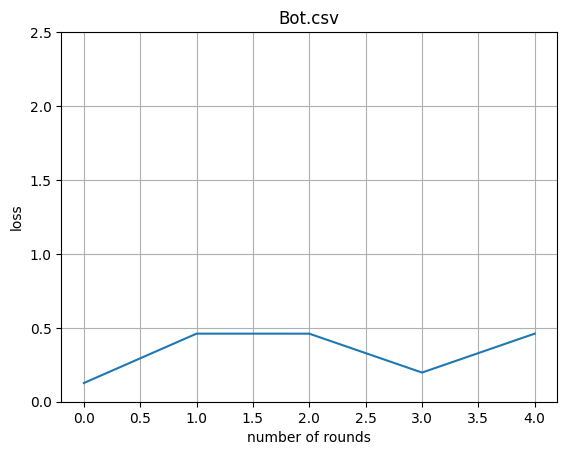

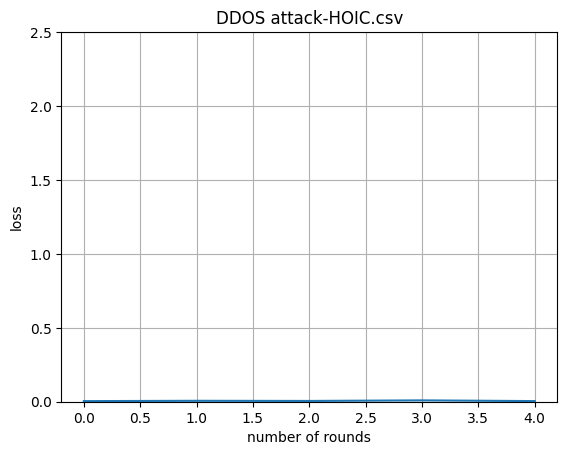

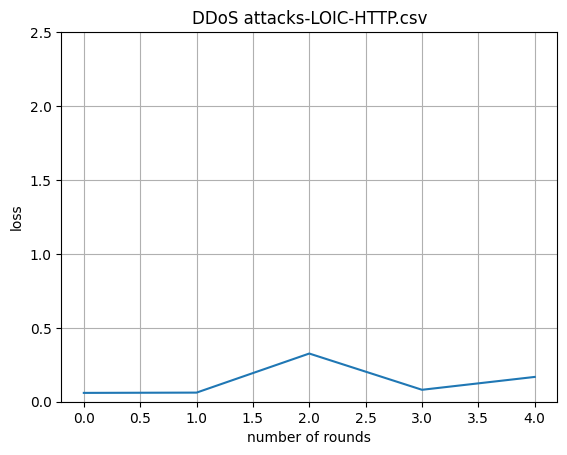

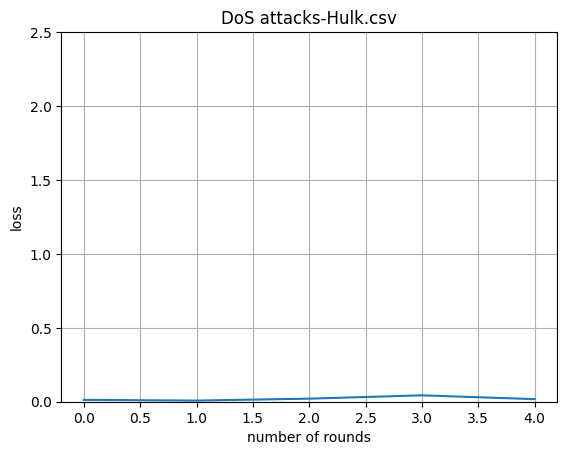

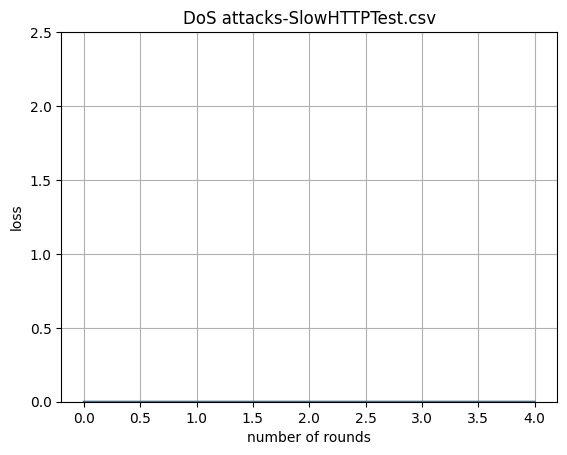

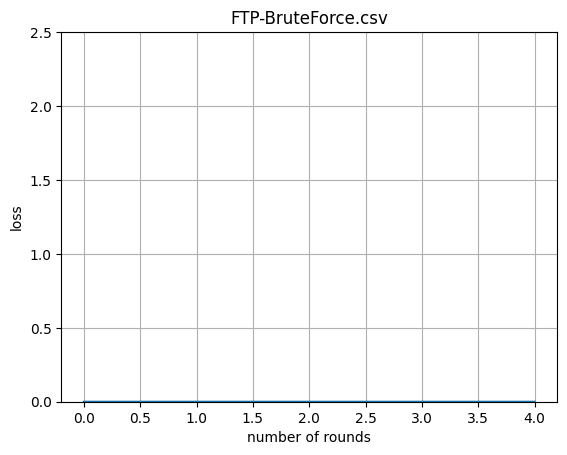

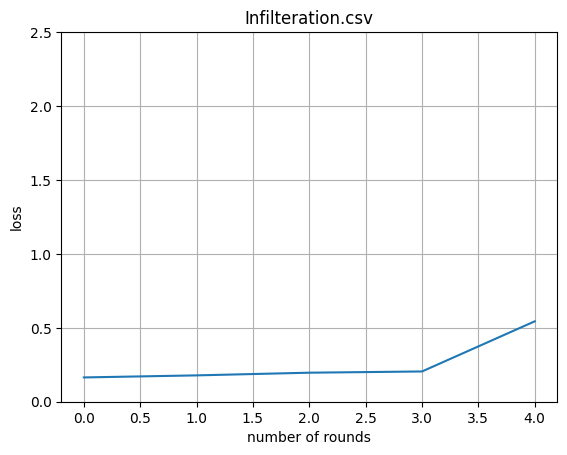

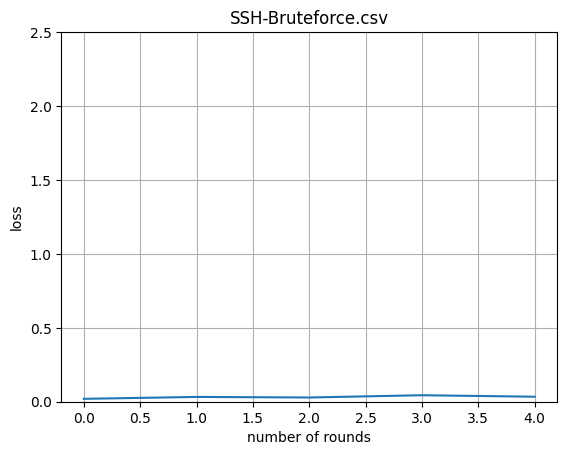

In [106]:
for i in range(len(devices)-1):
  printperformance(client_models[i], train_loss_per_client[i], devices[i])

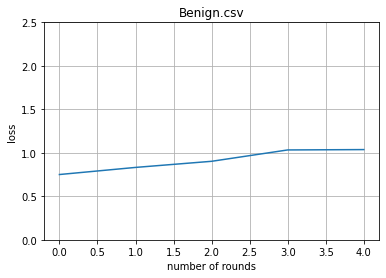

In [ ]:
# print performance of benign client
printperformance(client_models[-1], train_loss_benign, devices[-1])

In [56]:
'''
# train_loss_global
plt.plot(train_loss_global)
plt.xlabel('number of rounds')
plt.ylabel('loss')
plt.ylim((0, 2.5))
plt.grid()
plt.title('Federated Model with FedAvg (use five devices to train)')
plt.show()
'''

"\n# train_loss_global\nplt.plot(train_loss_global)\nplt.xlabel('number of rounds')\nplt.ylabel('loss')\nplt.ylim((0, 2.5))\nplt.grid()\nplt.title('Federated Model with FedAvg (use five devices to train)')\nplt.show()\n"

# Evaluation

In [107]:
client_models = []
for i in range(len(devices)):
  client_models.append(torch.load('E:/S7/Final Year Project//models/clients/' + devices[i] + '.pt'))

FileNotFoundError: [Errno 2] No such file or directory: 'E:/S7/Final Year Project//models/clients/Bot.csv.pt'

In [ ]:
from sklearn import metrics

In [ ]:
def get_thresh(model, dataloader):

    model.eval()
    errs = []
    for batch in dataloader:
       for data in batch:
         mse = np.mean(np.power(data.float().cpu().detach().numpy() - model(data.float()).cpu().detach().numpy(), 2), axis=0)
         thresh = mse.mean() + mse.std()
         errs.append(thresh)
    thresh = sum(errs) / len(errs)
    return thresh

    #model.eval()
    #pred = global_model(tr_data).cpu().detach().numpy()
    #print(pred)
    #print(np.isnan(pred))
    #thresh = np.sqrt(metrics.mean_squared_error(pred, threshben.numpy()))
    #mse = np.mean(np.power(tr_data.cpu().detach().numpy() - model(tr_data).cpu().detach().numpy(), 2), axis=1)
    #tr = np.sqrt(metrics.mean_squared_error(model(tr_data).cpu().detach().numpy(), tr_data.cpu().detach().numpy()))
    #tr = np.sqrt(mse)
    #return thresh
    
    
def quan_thresh(model, dataloader, quantile=0.9):

  model.eval()
  errs = []
  
  for batch in dataloader:
    
    mse = []
    for data in batch:
      error = np.power(data.float().cpu().numpy() - model(data.float()).cpu().detach().numpy(), 2)
      mse.append(error)
    
    # Calculate threshold as quantile of errors 
    thresh = np.quantile(mse, quantile)  
    errs.append(thresh)
    
  return np.mean(errs)

def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_pred)):
        if y_actual[i] == y_pred[i] == 1:
           TP += 1
        if y_pred[i] == 1 and y_actual[i] != y_pred[i]:
           FP += 1
        if y_actual[i] == y_pred[i] == 0:
           TN += 1
        if y_pred[i] == 0 and y_actual[i] != y_pred[i]:
           FN += 1
    return (TP, FP, TN, FN)

def get_mix_result(model, tr, mix_data, mix_label):
    model.eval()
    prediction = []
    for i in mix_data:
      pred = model(i).cpu().detach().numpy()
      error = np.sqrt(metrics.mean_squared_error(pred, threshben.numpy()))
      if error > tr:
        prediction.append(1)
      else:
        prediction.append(0)

    mix_label_list = mix_label.tolist()

    TP,FP,TN,FN = perf_measure(mix_label_list, prediction)

    conf = [[TP, FN],[FP, TN]]
    print(conf)
    x_axis_label = ['abnormal', 'benign']
    y_axis_label = ['abnormal', 'benign']

    plt.figure()
    sns.heatmap(conf,xticklabels=x_axis_label, yticklabels=y_axis_label, annot=True,annot_kws={"size": 16},fmt='g')

    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1score = 2 * ((precision * recall) / (precision + recall))

    TPR = round((TP / (TP+FN)), 6)
    # print('TPR is: {}%'.format(TPR))

    FPR = round((FP / (FP + TN)), 6)
    # print('TPR is: {}%'.format(FPR))

    print('Acc: %.3f%% \nPrecision: %.3f \nRecall: %.3f \nF1score: %.3f \nTPR: %.5f \nFPR: %.5f'%(acc*100,
                                                                                                   precision,
                                                                                                   recall,
                                                                                                   F1score*100,
                                                                                                   TPR,
                                                                                                   FPR))

#   [['TP', 'FN']
#   ['FP', 'TN']]

In [73]:
thresholds = {}
for i in range(len(devices)):
    model = client_models[i]
    dataloader = train_loader[devices[i]]
    thresholds[devices[i]] = quan_thresh(model, dataloader)
print(thresholds)

{'Bot.csv': 0.8188059830274742, 'DDOS attack-HOIC.csv': 1.7540655198530184, 'DDoS attacks-LOIC-HTTP.csv': 1.2256711142702144, 'DoS attacks-Hulk.csv': 1.1311297587059403, 'DoS attacks-SlowHTTPTest.csv': 1.0750234689290932, 'FTP-BruteForce.csv': 1.0826095469033017, 'Infilteration.csv': 1.3686508674731204, 'SSH-Bruteforce.csv': 2.193333827446048, 'Benign.csv': 0.15264720358032122}


In [33]:
'''thresholds_test = {}
for i in range(len(devices)):
    model = client_models[i]
    dataloader = test_loader[devices[i]]
    thresholds_test[devices[i]] = get_thresh(model, dataloader)
print(thresholds_test)'''

'thresholds_test = {}\nfor i in range(len(devices)):\n    model = client_models[i]\n    dataloader = test_loader[devices[i]]\n    thresholds_test[devices[i]] = get_thresh(model, dataloader)\nprint(thresholds_test)'

In [74]:
len(thresholds)

9

In [75]:
devices

['Bot.csv',
 'DDOS attack-HOIC.csv',
 'DDoS attacks-LOIC-HTTP.csv',
 'DoS attacks-Hulk.csv',
 'DoS attacks-SlowHTTPTest.csv',
 'FTP-BruteForce.csv',
 'Infilteration.csv',
 'SSH-Bruteforce.csv',
 'Benign.csv']

In [76]:
test_loader

{'Bot.csv': <torch.utils.data.dataloader.DataLoader at 0x1e116789610>,
 'DDOS attack-HOIC.csv': <torch.utils.data.dataloader.DataLoader at 0x1e1161ea490>,
 'DDoS attacks-LOIC-HTTP.csv': <torch.utils.data.dataloader.DataLoader at 0x1e11676b350>,
 'DoS attacks-Hulk.csv': <torch.utils.data.dataloader.DataLoader at 0x1e1161101d0>,
 'DoS attacks-SlowHTTPTest.csv': <torch.utils.data.dataloader.DataLoader at 0x1e1167a1610>,
 'FTP-BruteForce.csv': <torch.utils.data.dataloader.DataLoader at 0x1e1167a3510>,
 'Infilteration.csv': <torch.utils.data.dataloader.DataLoader at 0x1e1167a1190>,
 'SSH-Bruteforce.csv': <torch.utils.data.dataloader.DataLoader at 0x1e1167a1290>}

C:\Users\adith\AppData\Local\Temp\ipykernel_15632\2282056968.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


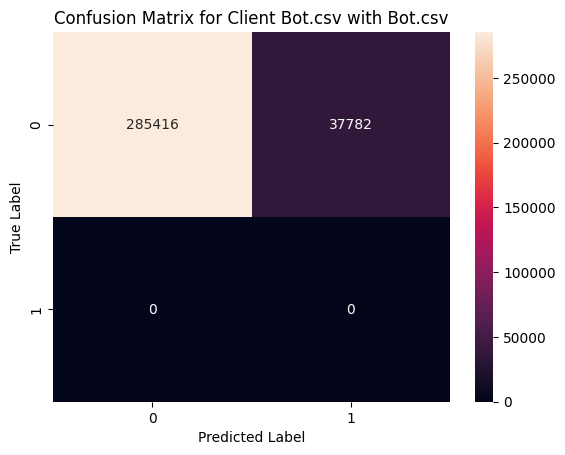

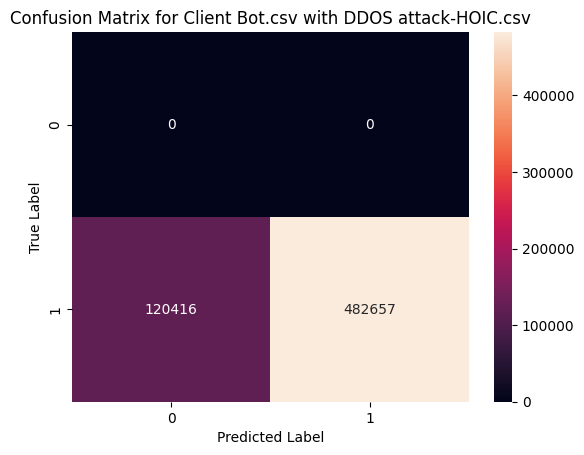

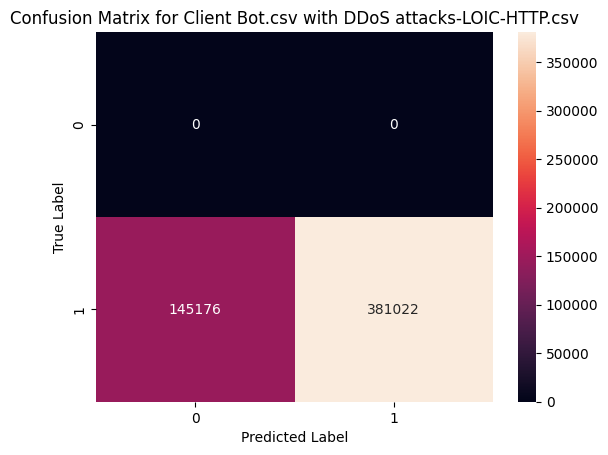

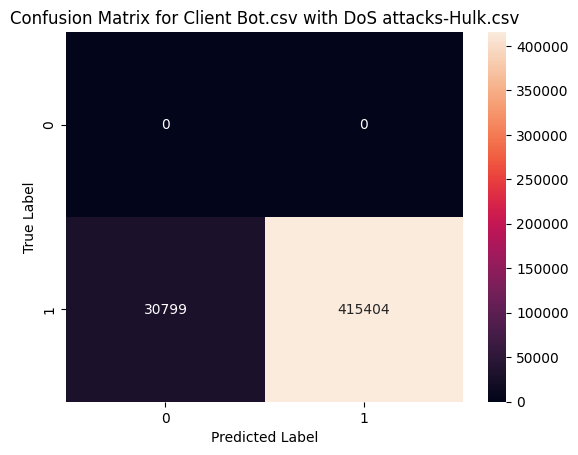

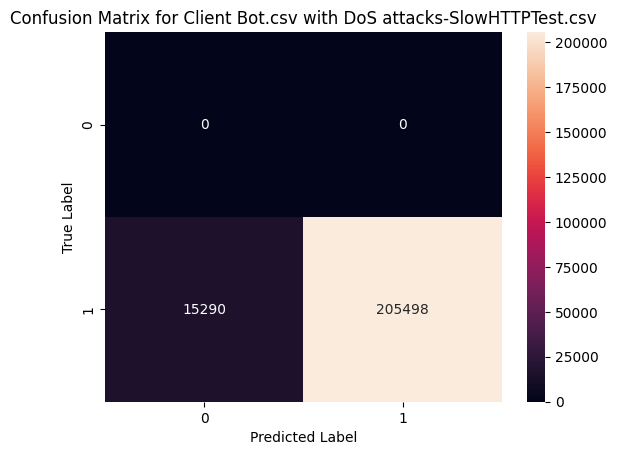

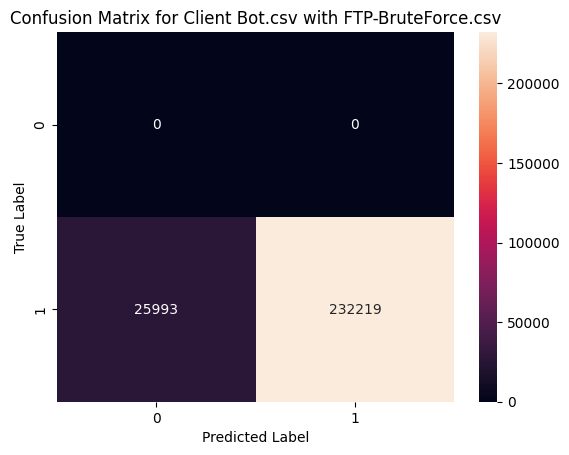

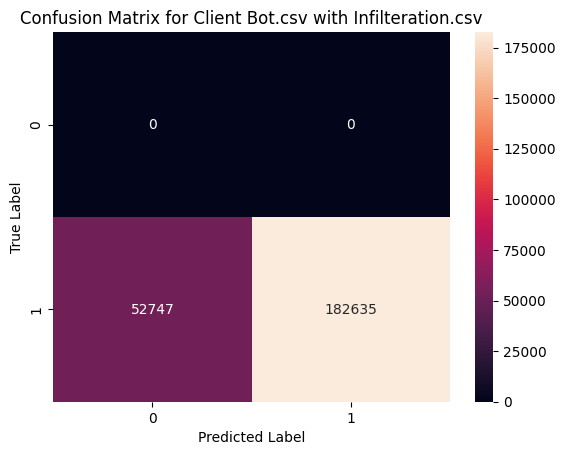

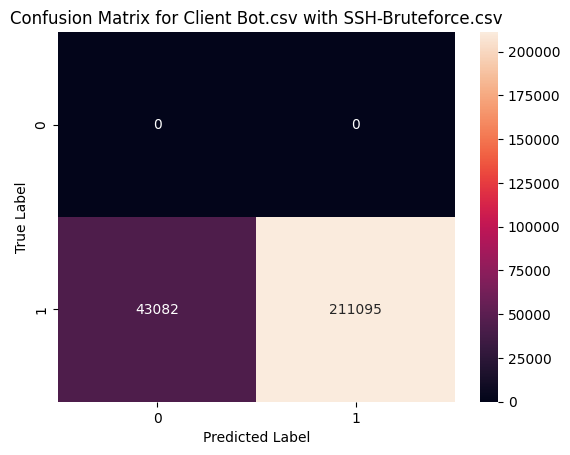

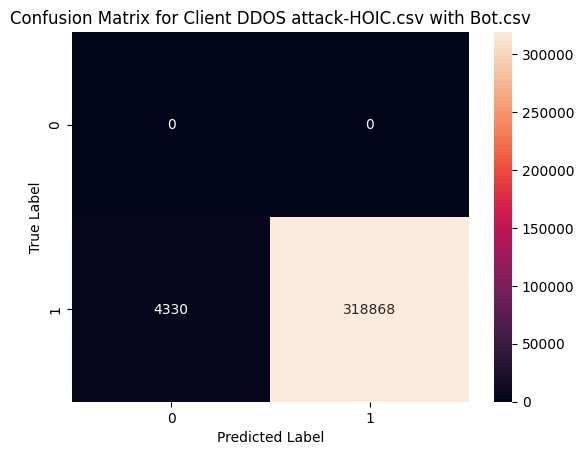

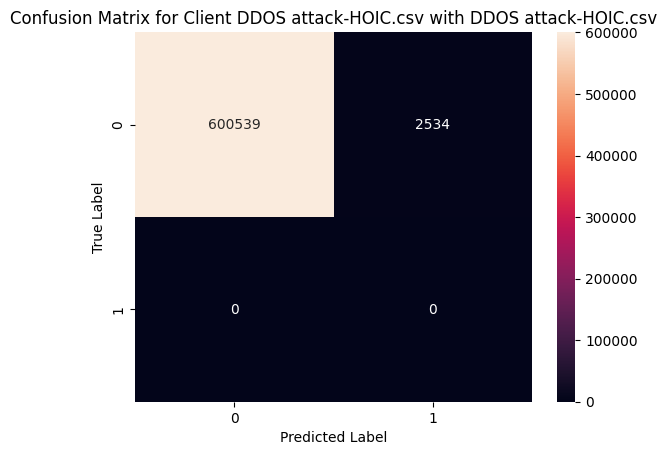

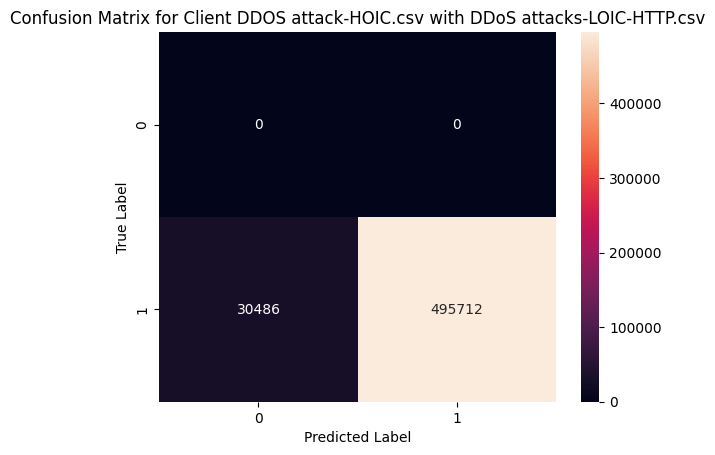

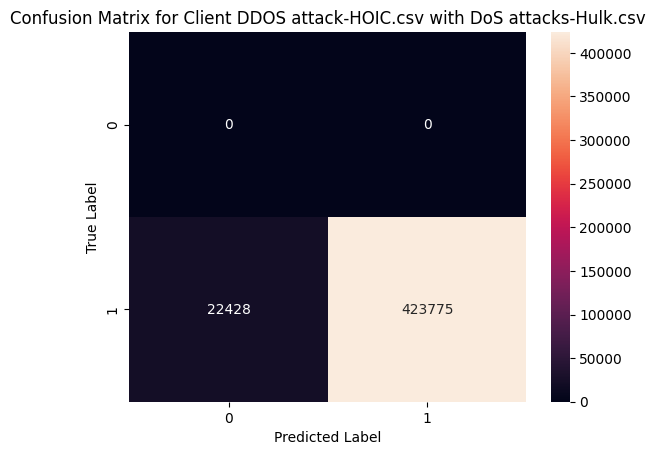

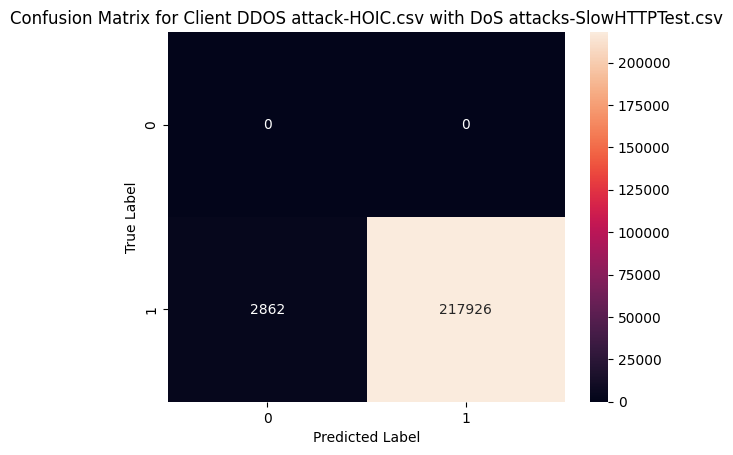

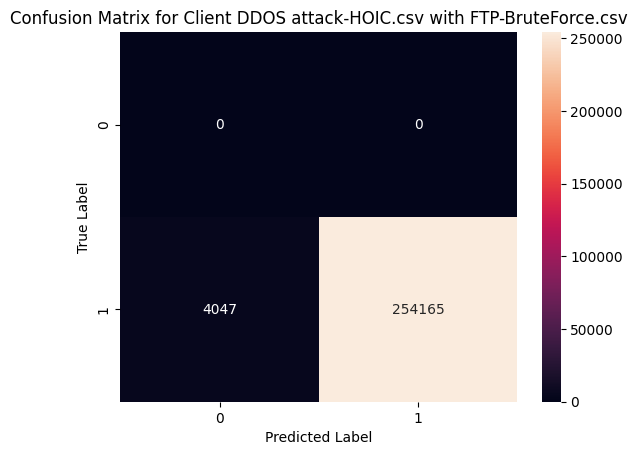

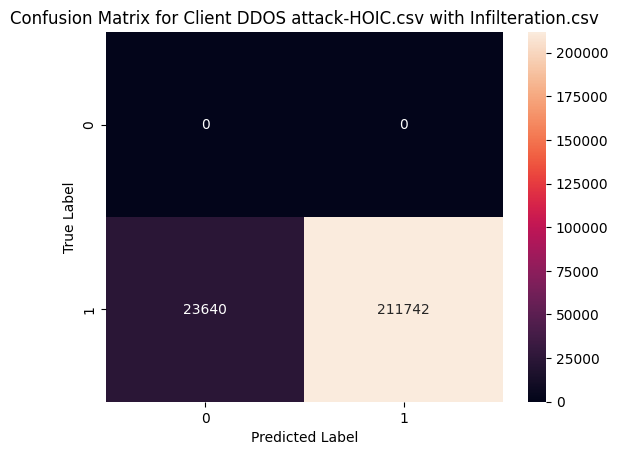

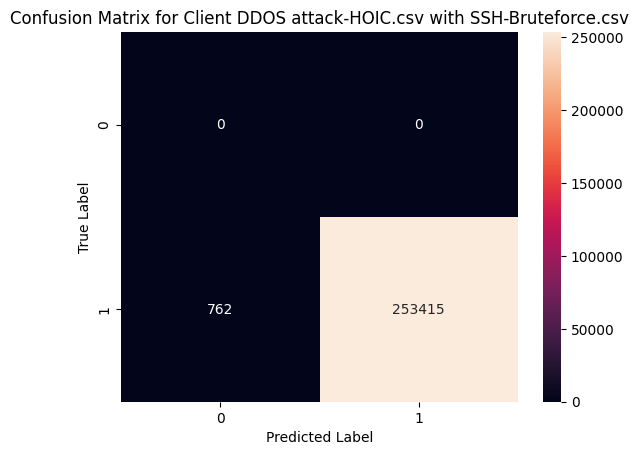

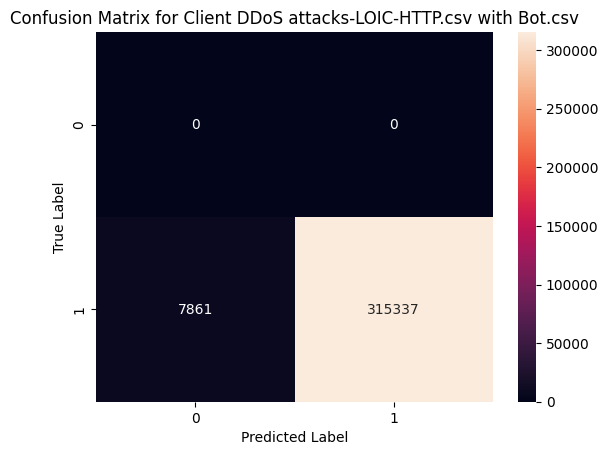

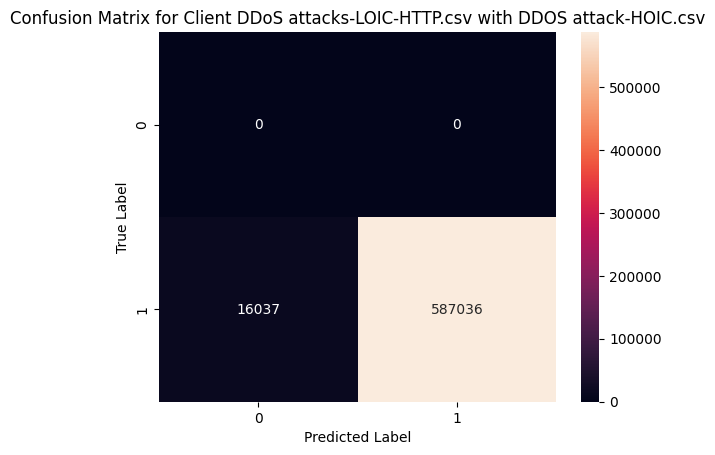

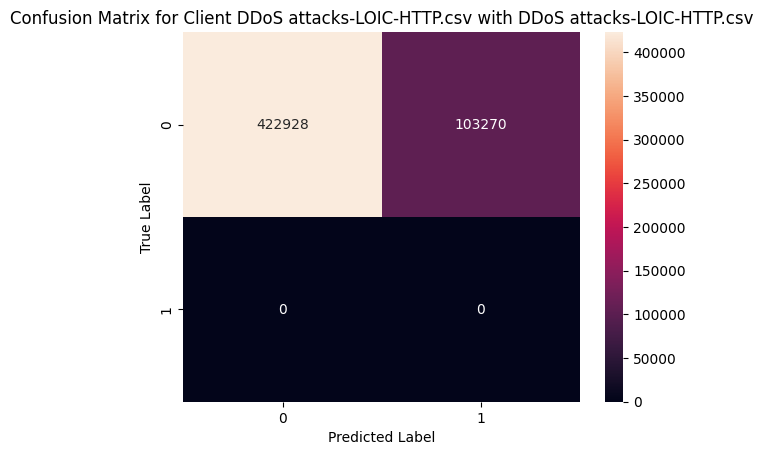

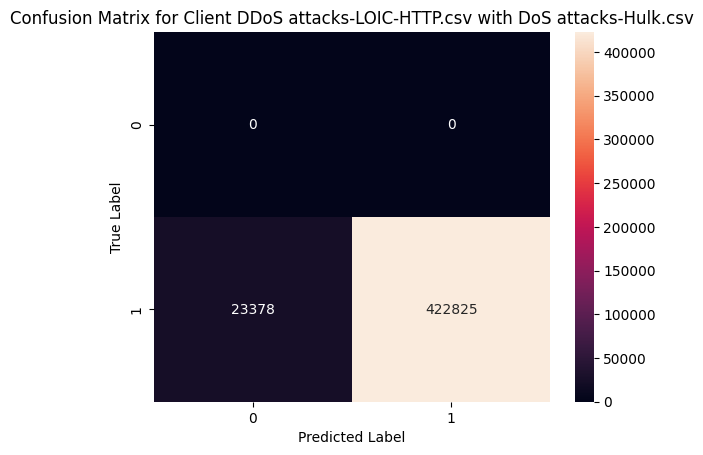

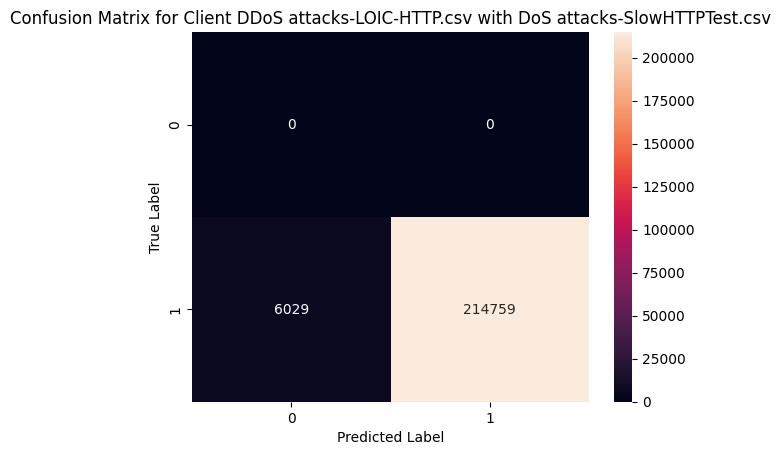

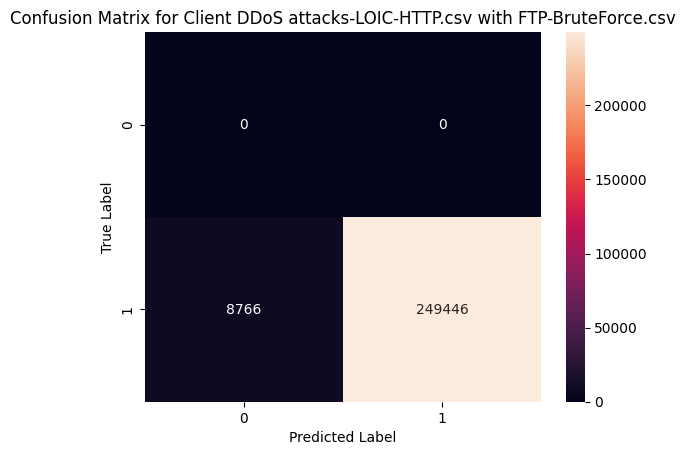

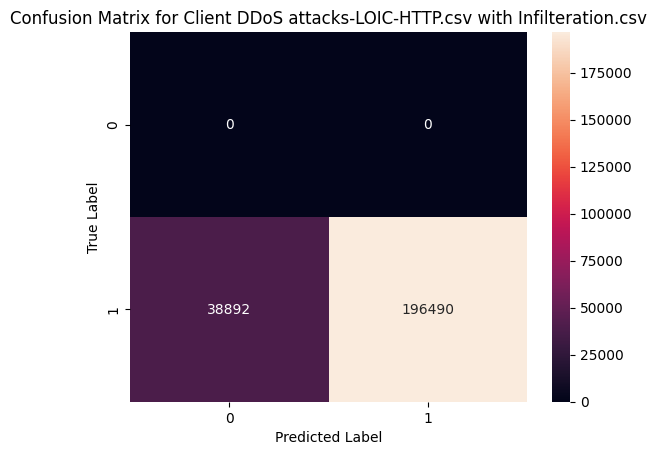

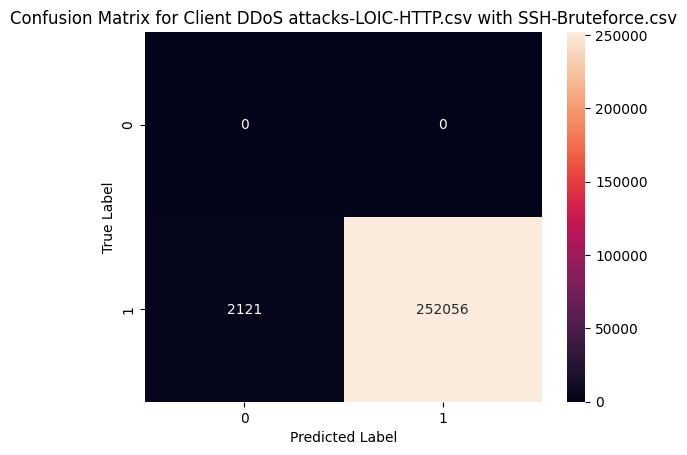

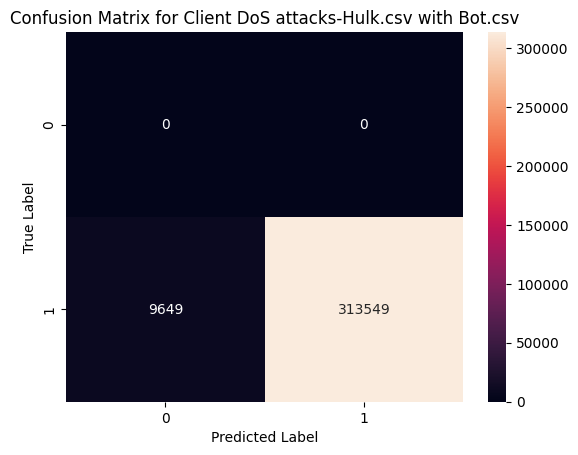

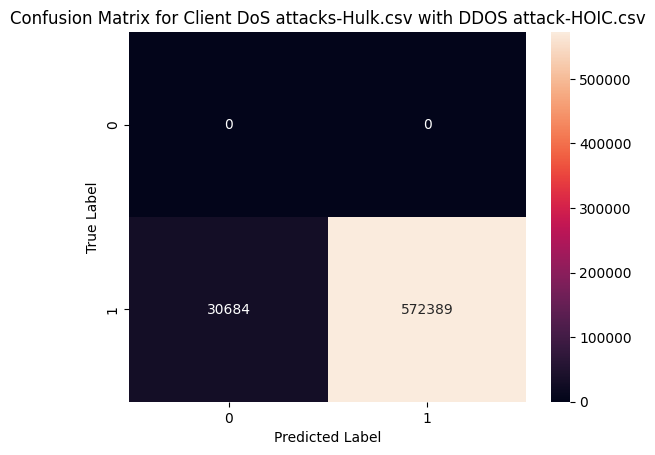

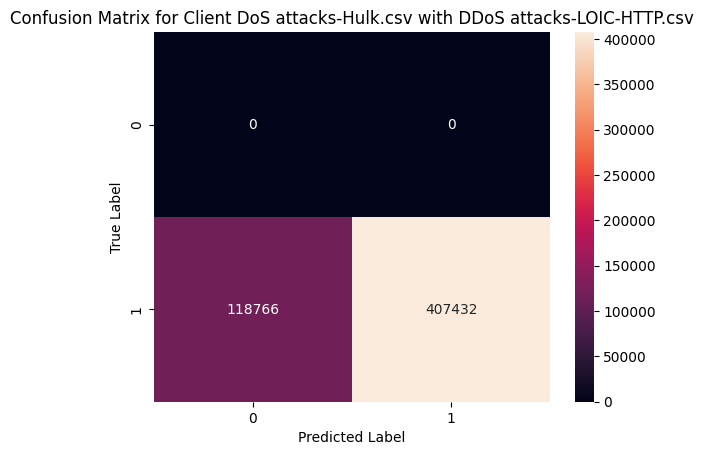

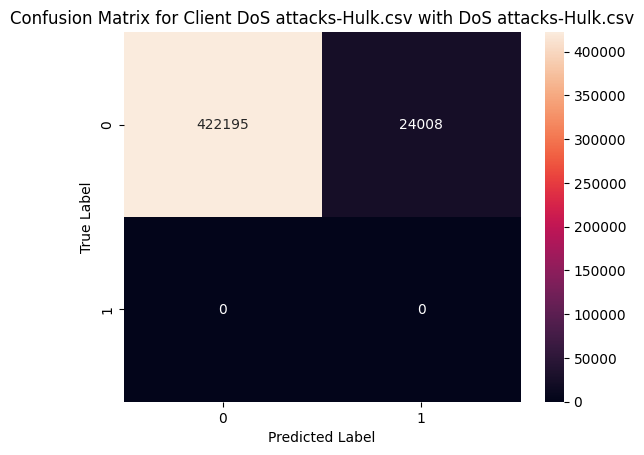

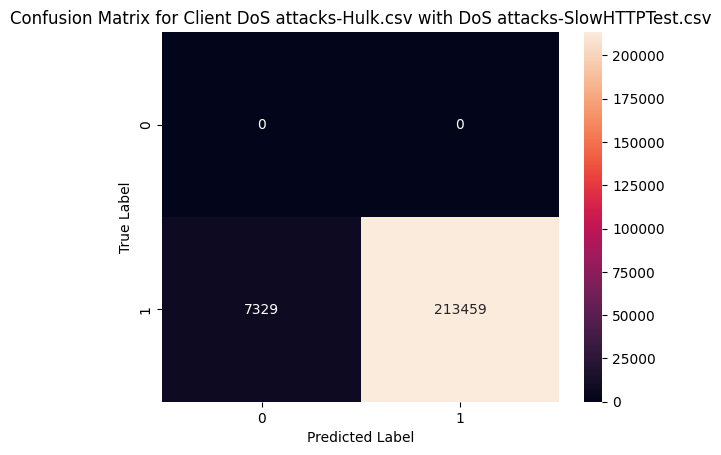

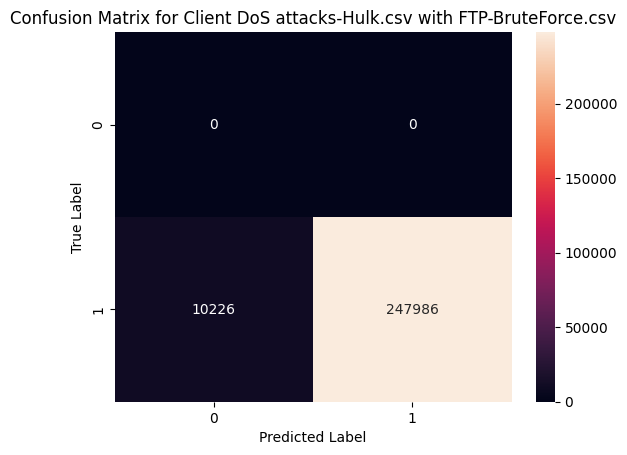

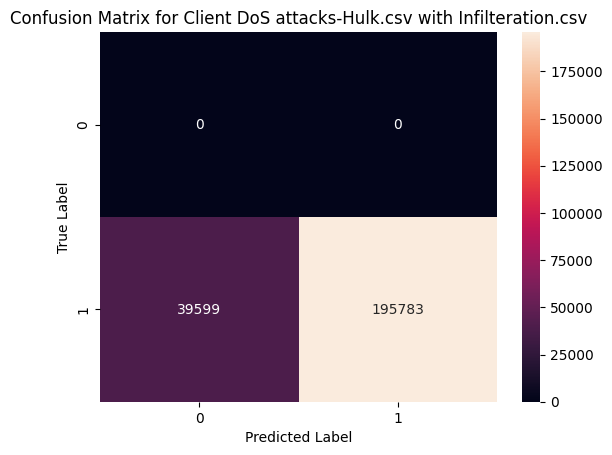

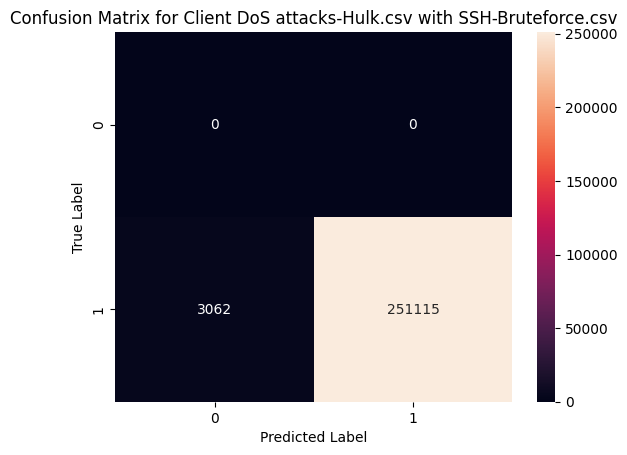

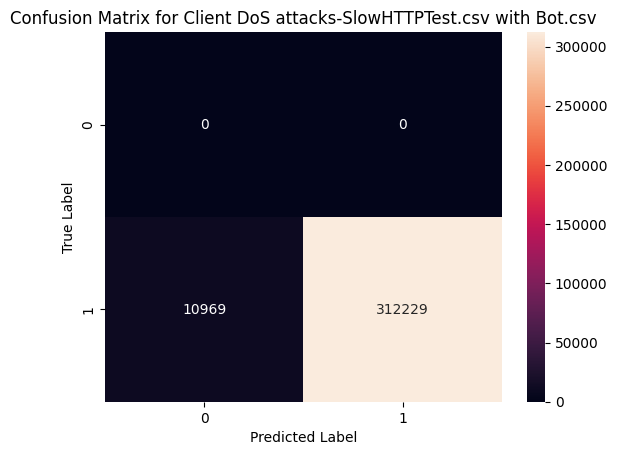

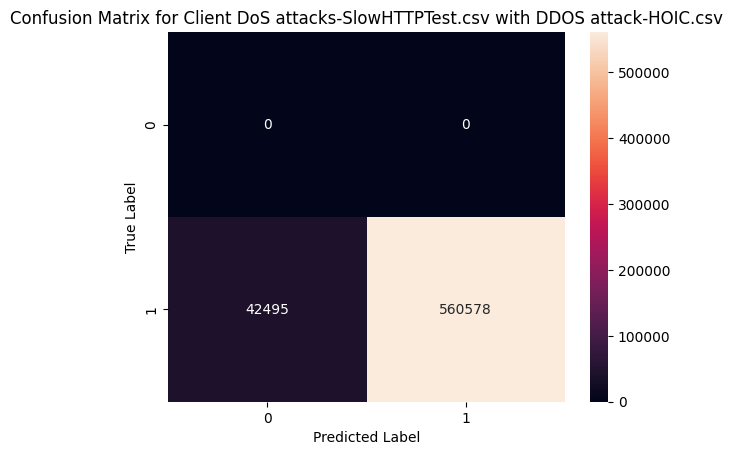

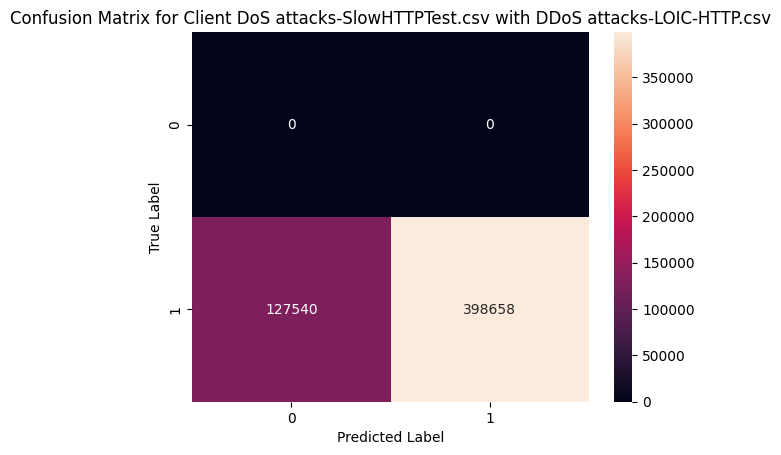

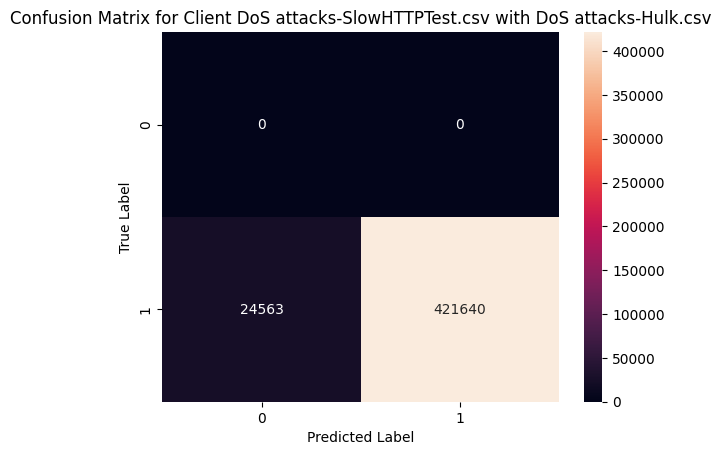

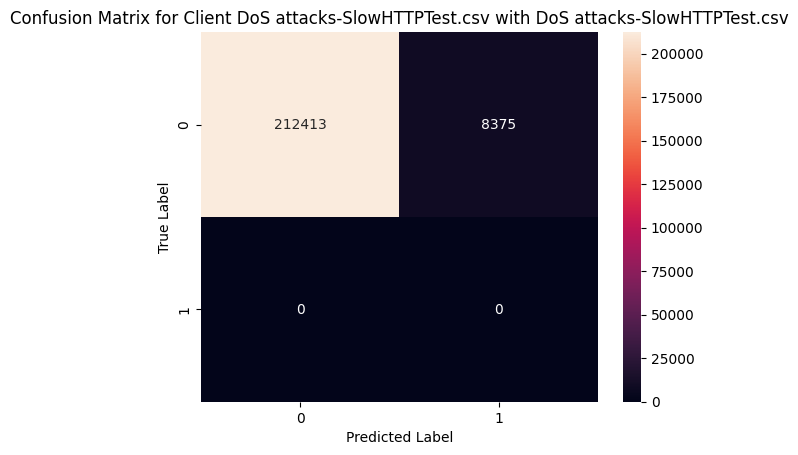

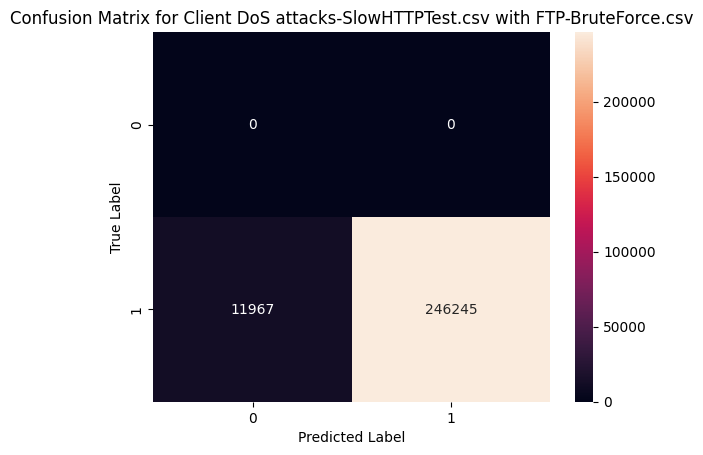

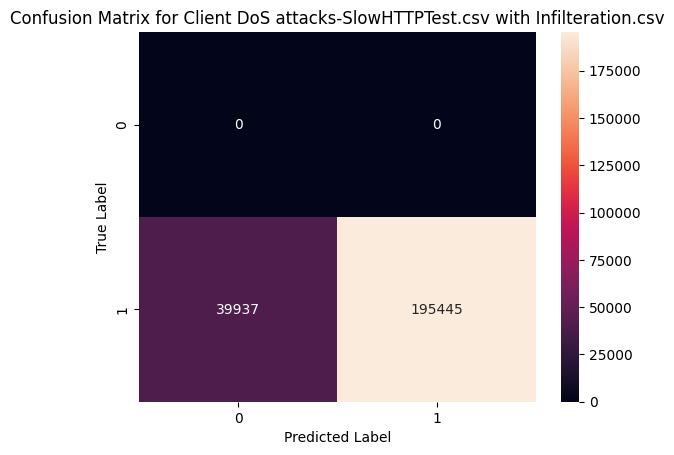

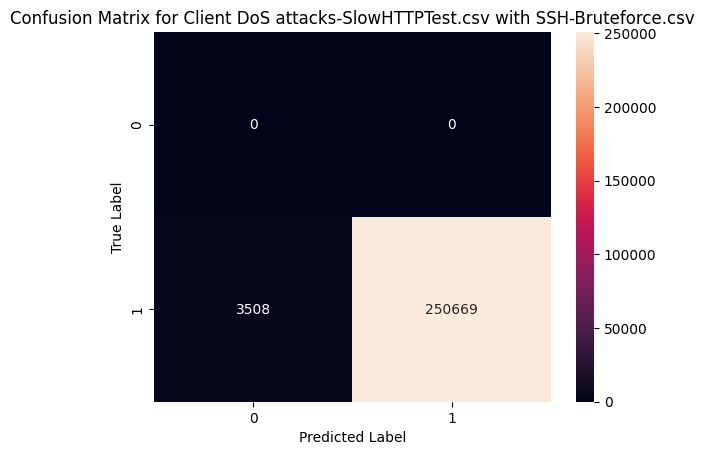

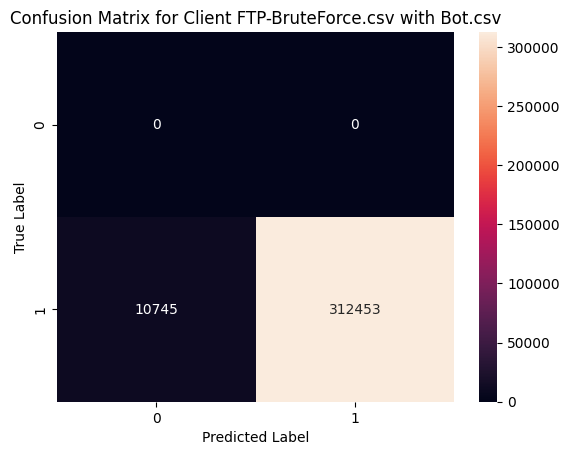

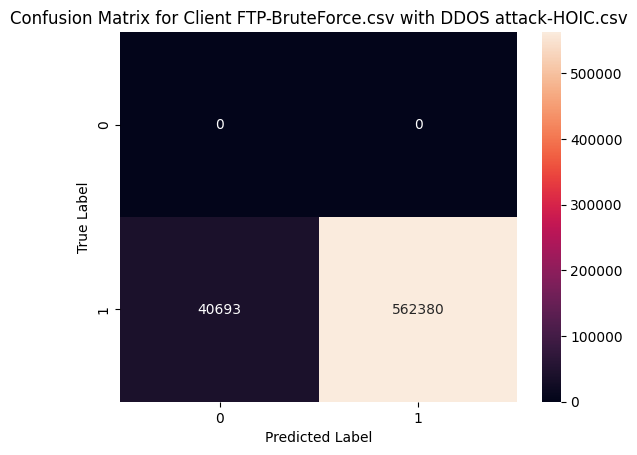

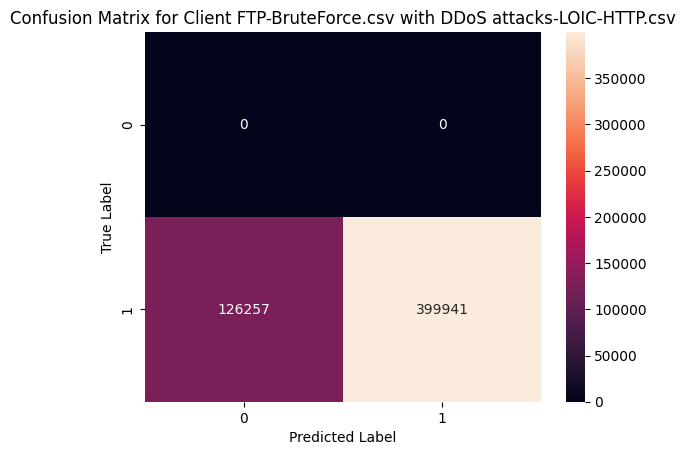

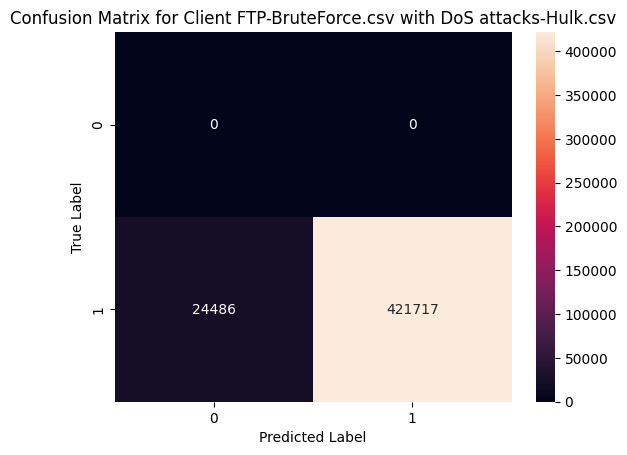

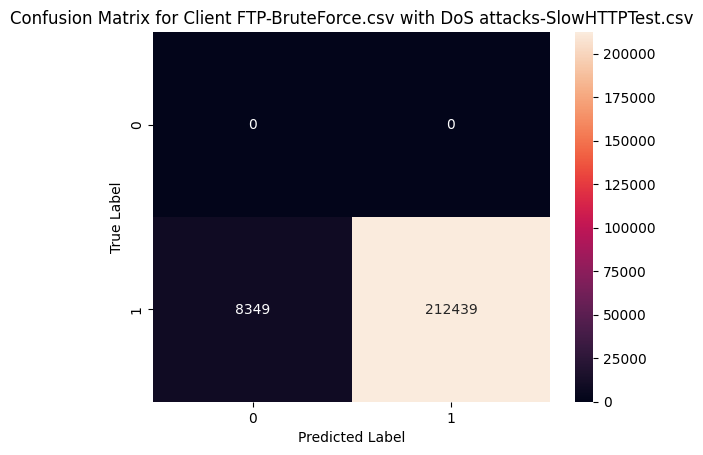

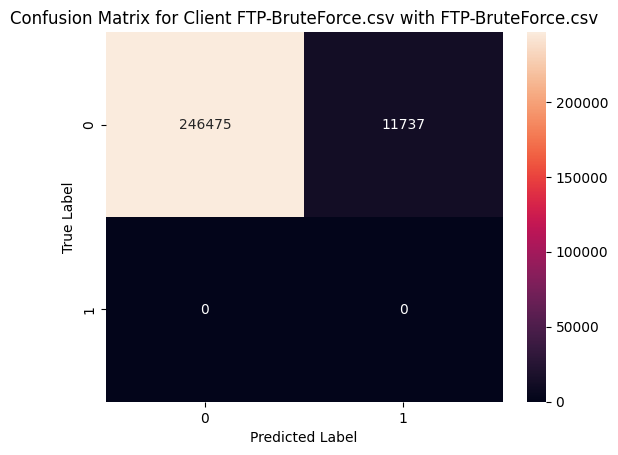

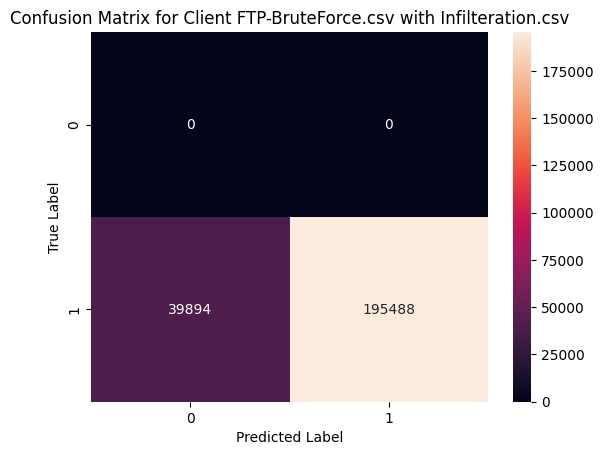

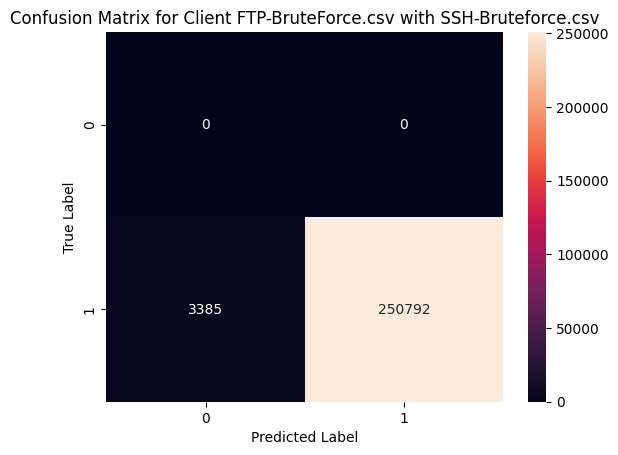

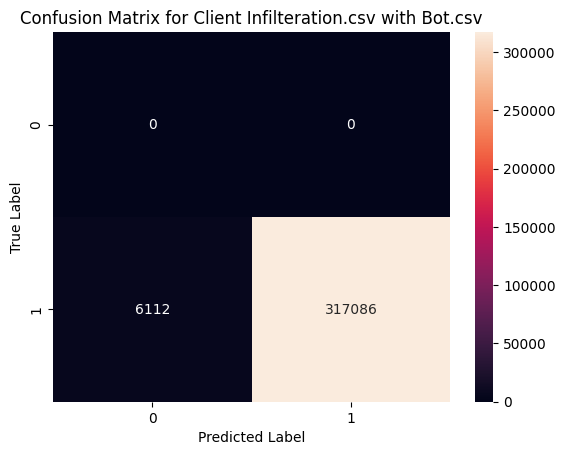

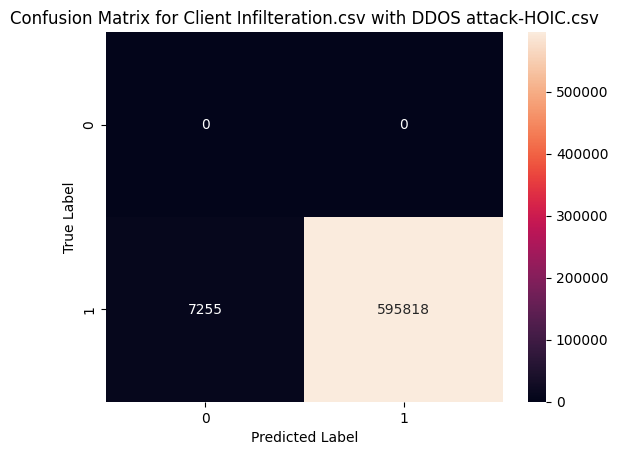

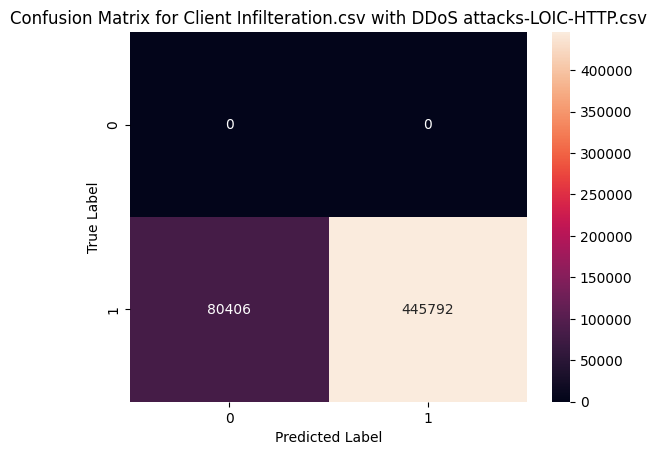

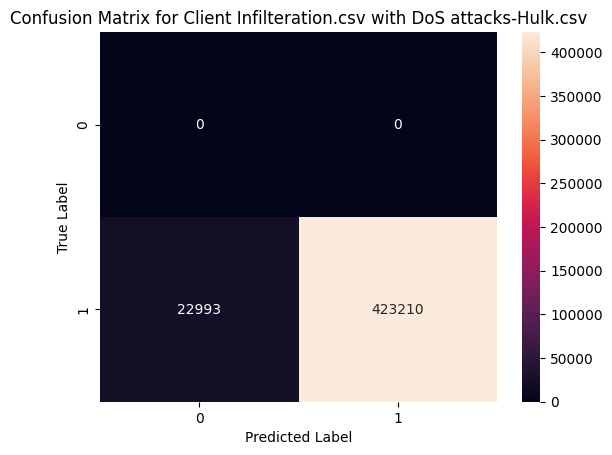

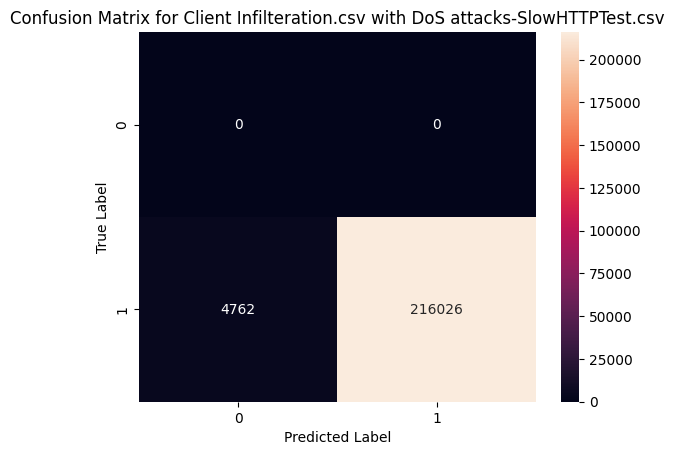

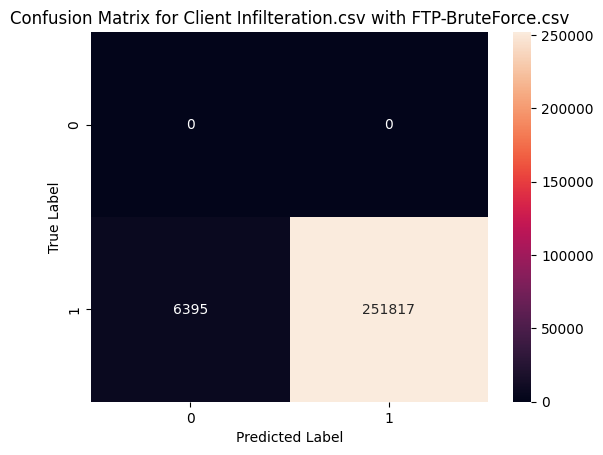

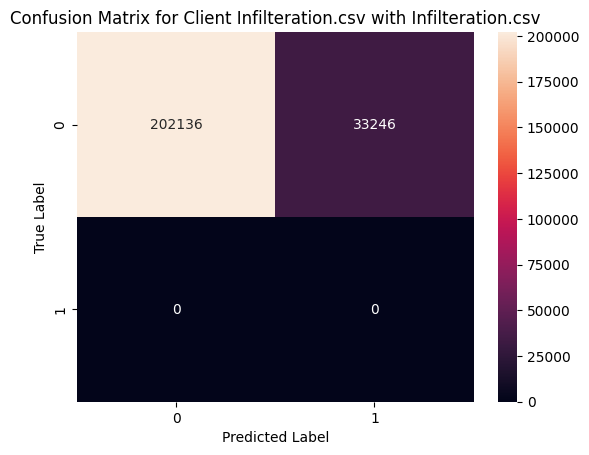

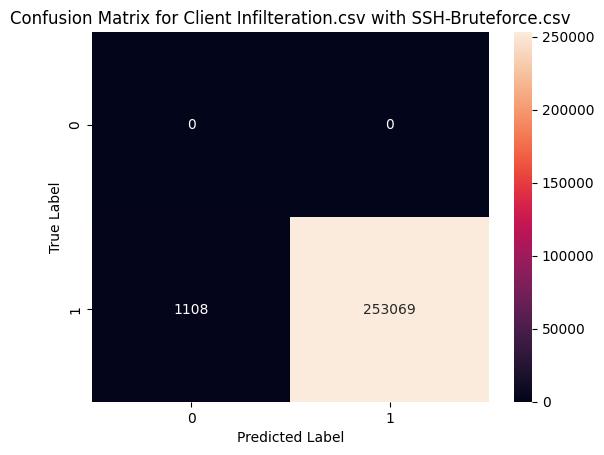

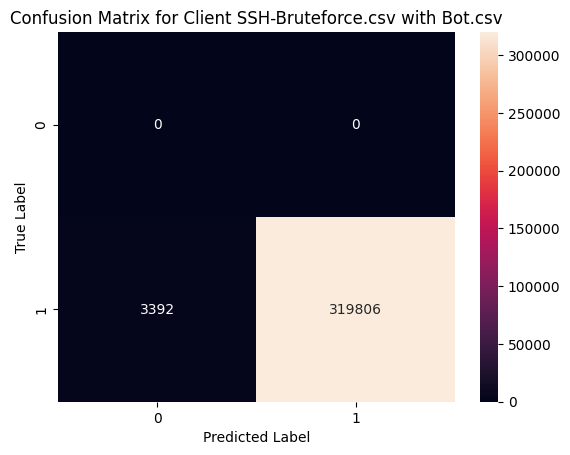

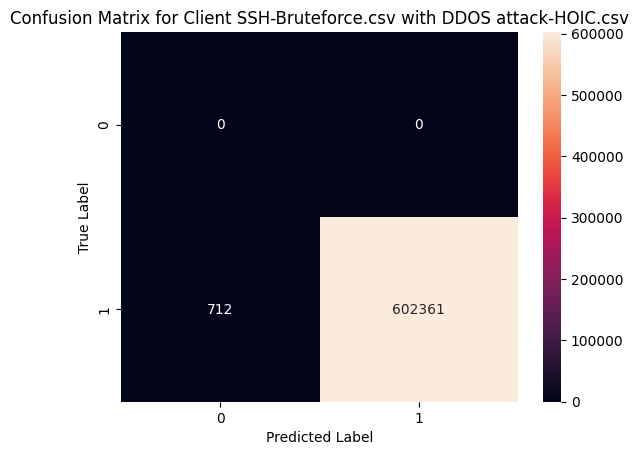

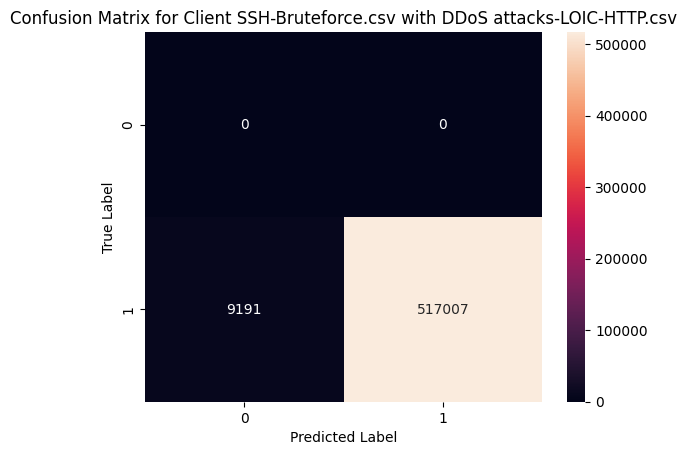

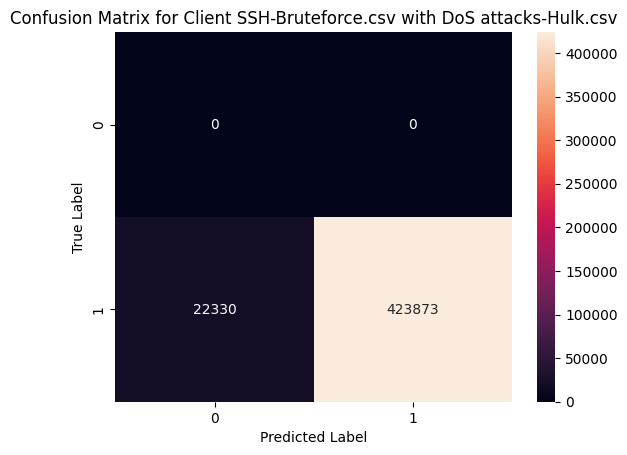

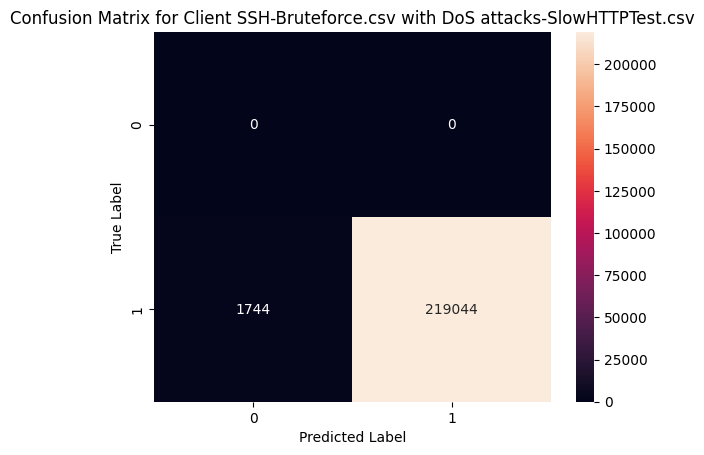

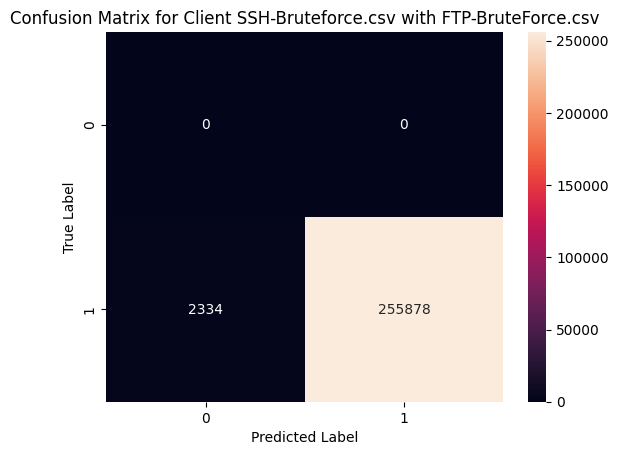

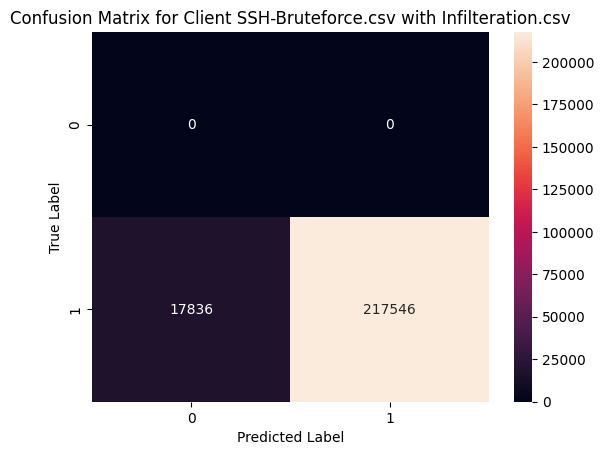

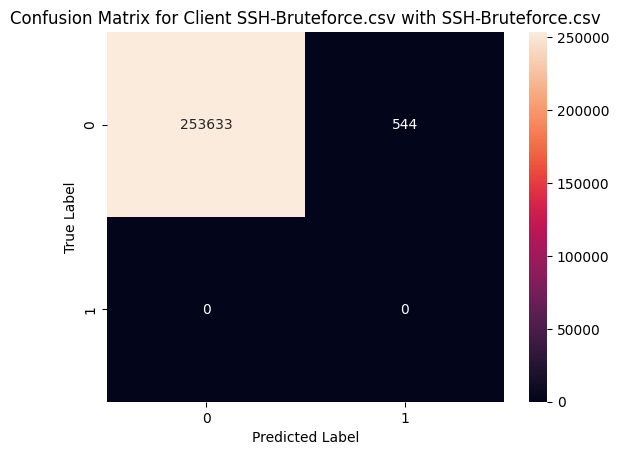

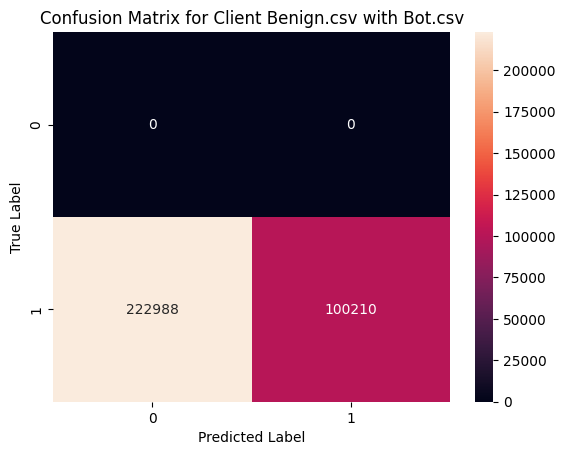

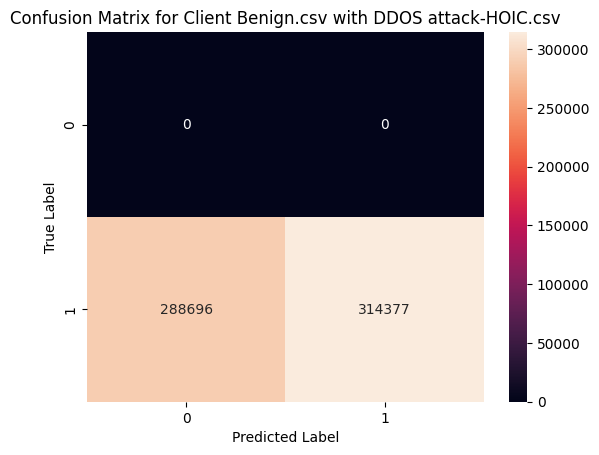

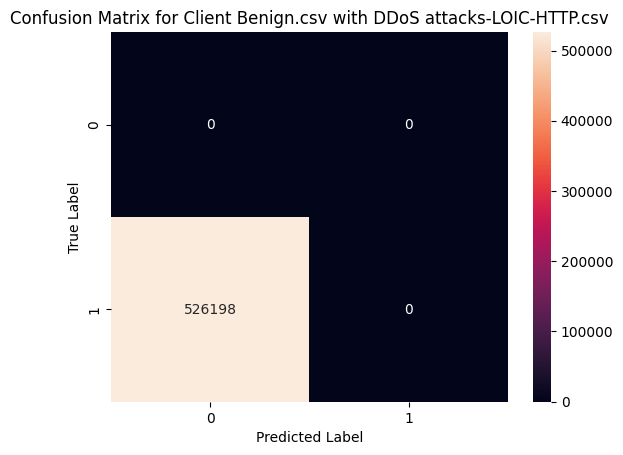

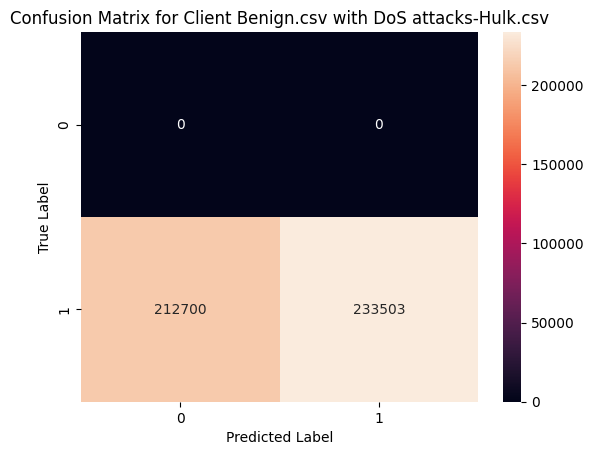

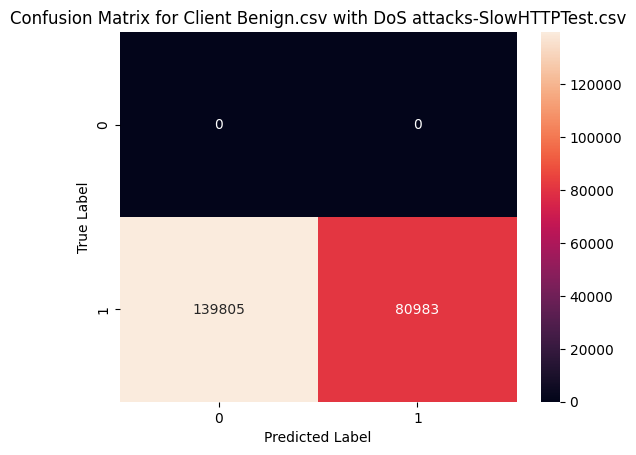

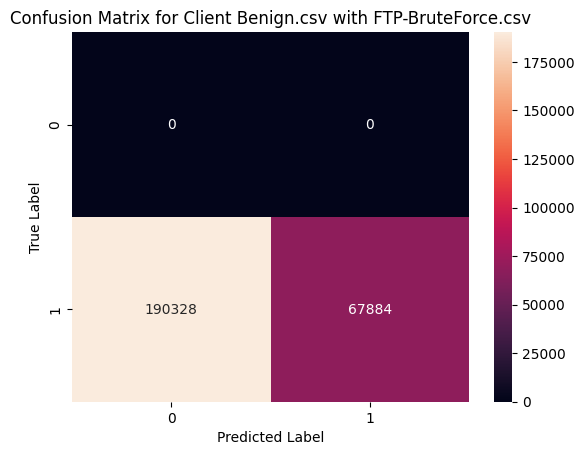

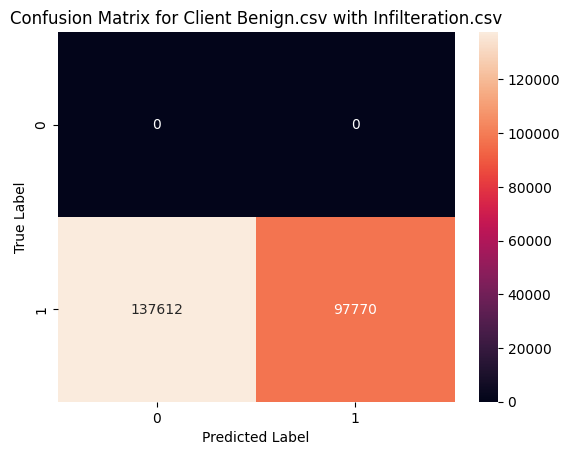

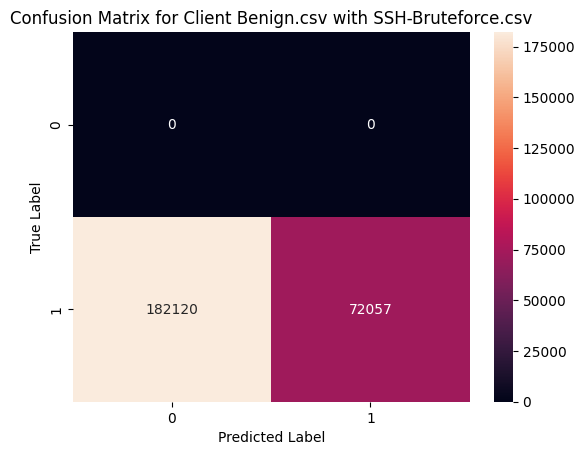

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

device_idx = {device: i for i, device in enumerate(devices)}
for device in devices:
  model = client_models[device_idx[device]]
  threshold = thresholds[device]
  for i in attbenmixdata_loader:
    test_set = attbenmixdata_loader[i]
    labels = list(attbenmixdatalabels[i])
    y_true = []
    y_pred = []
    for batch in test_set:
      for data in batch:
        pred = model(data.float())
        error = torch.mean((pred.float() - data.float())**2, dim=tuple(range(1,pred.ndim)))
        if device == i:
          y_true.append(1)
          y_pred.append(1 if error <= threshold else 0)
        else:
          y_true.append(0)
          y_pred.append(0 if error <= threshold else 1)
    TP, FP, TN, FN = perf_measure(y_true, y_pred)
    conf_matrix = [[TP, FN], [FP, TN]]
    plt.figure() 
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.title("Confusion Matrix for Client " + str(device) +" with "+ str(i))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

#   [['TP', 'FN']
#   ['FP', 'TN']]

In [ ]:
# load model
global_model = torch.load('C:/Final Year Project/models/alldataglobal.pt')                                        

# Test on client devices

In [ ]:
threshben.drop(['Label'], axis=1, inplace=True)

In [ ]:
threshben = torch.from_numpy(np.array(threshben)).float().to(device)

In [ ]:
print(threshben)

In [ ]:
tensor_data = torch.cat([batch for batch in train_loader['D1']], dim=0)

In [ ]:
predtrain = global_model(tensor_data).cpu().detach().numpy()
print(predtrain)

In [ ]:
pred = global_model(threshben).cpu().detach().numpy()
print(pred)

In [ ]:
thresh = get_thresh(global_model, threshben)

In [ ]:
thresh.shape

In [ ]:
thresh

In [ ]:
# use global model & device's TR
testset = torch.from_numpy(np.array(testset)).float().to(device)
print("D1: ")
get_mix_result(global_model, thresh, testset, testlabels)